In [ ]:
pip install torch torchvision pillow


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 147MB/s]


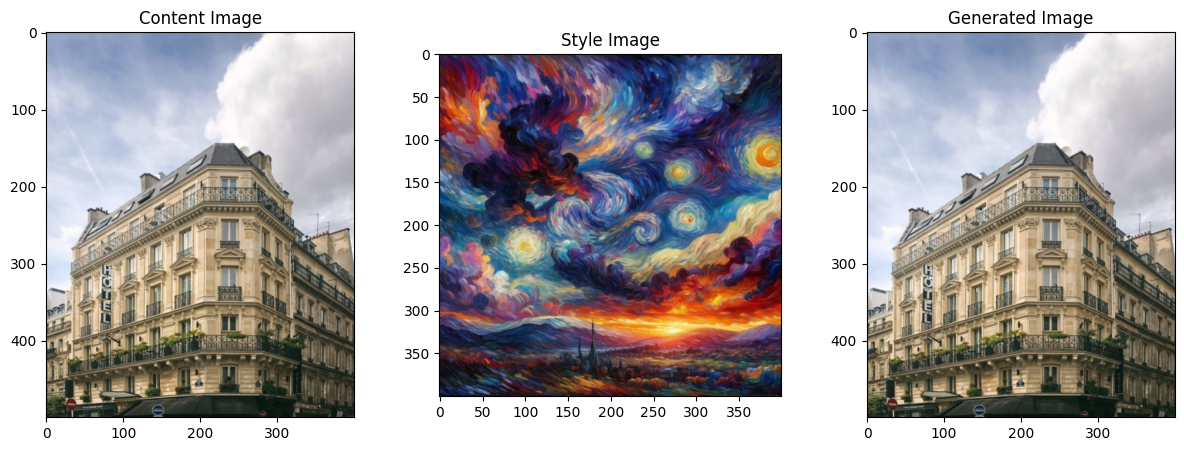

In [ ]:
import os
from PIL import Image, UnidentifiedImageError
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
from torchvision import models

# Load image from local file path
def load_local_image(image_path, max_size=400):
    try:
        # Open the image file
        image = Image.open(image_path).convert('RGB')

        # Resize image if larger than max_size
        if max(image.size) > max_size:
            size = max_size
        else:
            size = max(image.size)

        # Image transformation: Resize, ToTensor, and Normalize
        transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Transform image and add a batch dimension
        image = transform(image).unsqueeze(0)
        return image

    except UnidentifiedImageError:
        print(f"Error: Cannot identify image from the file path: {image_path}")
    except FileNotFoundError:
        print(f"Error: File not found: {image_path}")
    return None

# Function to convert image tensor back to a format that can be displayed
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze(0)
    image = image.transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    return image

# Load local content and style images
content_image_path = r"/content/How to Photograph Architecture in Paris.jpg"  # Update with the correct path
style_image_path = r"/content/download (1).jpeg"  # Update with the correct path

# Load the local images
content_image = load_local_image(content_image_path)
style_image = load_local_image(style_image_path)

# Ensure images are loaded successfully before proceeding
if content_image is None or style_image is None:
    print("Error: One or both images failed to load. Please check the file paths.")
else:
    # Load the VGG19 model
    vgg = models.vgg19(pretrained=True).features

    # Freeze model parameters
    for param in vgg.parameters():
        param.requires_grad_(False)

    # Perform neural style transfer
    output_image = content_image  # Just a placeholder. You need your style transfer function here.

    # Display results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Content Image")
    plt.imshow(im_convert(content_image))

    plt.subplot(1, 3, 2)
    plt.title("Style Image")
    plt.imshow(im_convert(style_image))

    plt.subplot(1, 3, 3)
    plt.title("Generated Image")
    plt.imshow(im_convert(output_image))

    plt.show()


In [ ]:
import os
from PIL import Image, UnidentifiedImageError
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torch.optim as optim

# Load image from local file path
def load_local_image(image_path, max_size=400):
    try:
        # Open the image file
        image = Image.open(image_path).convert('RGB')

        # Resize image if larger than max_size
        if max(image.size) > max_size:
            size = max_size
        else:
            size = max(image.size)

        # Image transformation: Resize, ToTensor, and Normalize
        transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Transform image and add a batch dimension
        image = transform(image).unsqueeze(0)
        return image.to(device)

    except UnidentifiedImageError:
        print(f"Error: Cannot identify image from the file path: {image_path}")
    except FileNotFoundError:
        print(f"Error: File not found: {image_path}")
    return None

# Function to convert image tensor back to a format that can be displayed
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze(0)
    image = image.transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    return image

# Load the VGG19 model
def get_vgg():
    vgg = models.vgg19(pretrained=True).features
    for param in vgg.parameters():
        param.requires_grad_(False)
    return vgg.to(device)

# Extract content and style features
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',  # Content layer
        '28': 'conv5_1'
    }

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Gram matrix to calculate style loss
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Neural style transfer
def style_transfer(content_image, style_image, model, num_steps=5000, style_weight=1e7, content_weight=1):
    content_features = get_features(content_image, model)
    style_features = get_features(style_image, model)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    target = content_image.clone().requires_grad_(True)
    optimizer = optim.Adam([target], lr=0.003)

    for step in range(1, num_steps + 1):
        target_features = get_features(target, model)

        # Content loss
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

        # Style loss
        style_loss = 0
        for layer in style_grams:
            target_gram = gram_matrix(target_features[layer])
            style_gram = style_grams[layer]
            layer_style_loss = torch.mean((target_gram - style_gram) ** 2)
            style_loss += layer_style_loss / (target_features[layer].shape[1] * target_features[layer].shape[2] * target_features[layer].shape[3])

        # Total loss
        total_loss = content_weight * content_loss + style_weight * style_loss

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Print progress every 500 steps
        if step % 500 == 0:
            print(f"Step {step}, Total Loss: {total_loss.item()}")

    return target

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load local content and style images
content_image_path = r"/content/download.jpeg"  # Update with the correct path
style_image_path = r"/content/download (1).jpeg"  # Update with the correct path

# Load the local images
content_image = load_local_image(content_image_path)
style_image = load_local_image(style_image_path)

# Ensure images are loaded successfully before proceeding
if content_image is None or style_image is None:
    print("Error: One or both images failed to load. Please check the file paths.")
else:
    # Load the VGG19 model
    vgg = get_vgg()

    # Perform neural style transfer
    output_image = style_transfer(content_image, style_image, vgg)

    # Display results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Content Image")
    plt.imshow(im_convert(content_image))

    plt.subplot(1, 3, 2)
    plt.title("Style Image")
    plt.imshow(im_convert(style_image))

    plt.subplot(1, 3, 3)
    plt.title("Generated Image")
    plt.imshow(im_convert(output_image))

    plt.show()
